In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import math
plt.style.use('seaborn-notebook')

# DeepMoD stuff
from deepymod_torch.DeepMod import DeepMod
from deepymod_torch.library_functions import library_basic_damped_pen
from deepymod_torch.utilities import create_deriv_data, terms_definition

# Setting cuda if GPU is available
if torch.cuda.is_available():
    torch.set_default_tensor_type('torch.cuda.FloatTensor')

# Settings for reproducibility
np.random.seed(4)
torch.manual_seed(3)



/opt/conda/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:544: FutureWa

In [2]:
from scipy.integrate import odeint
def dU_dx(U, x):
    # Here U is a vector such that y=U[0] and z=U[1]. This function should return [y', z']
    return [U[1], -10*math.sin(U[0])-U[1]]
U0 = [0.25, 0.0]
xs = np.linspace(0, 5, 1500)
Us = odeint(dU_dx, U0, xs)
ys = Us[:,0]

In [3]:
X=xs.reshape(xs.size,1)
X.shape

(1500, 1)

In [4]:
y=Us/np.max(np.abs(Us),axis=0)
y.shape

(1500, 2)

In [5]:
number_of_samples = 1000

idx = np.random.permutation(y.shape[0])
X_train = torch.tensor(X[idx, :][:number_of_samples], dtype=torch.float32)
y_train = torch.tensor(y[idx, :][:number_of_samples], dtype=torch.float32,requires_grad=True)

In [6]:
print(X_train.shape, y_train.shape)

torch.Size([1000, 1]) torch.Size([1000, 2])


In [7]:
config = {'input_dim': 1, 'hidden_dim': 40, 'layers': 6, 'output_dim': 2, 'library_function': library_basic_damped_pen, 'library_args':{'poly_order': 1, 'diff_order': 1}}

In [8]:
model = DeepMod(config)

In [9]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
X_input = create_deriv_data(X_train, config['library_args']['diff_order'])

In [10]:
X_input[1].shape

torch.Size([1000, 1, 1, 1])

In [11]:
q = model(X_input)

In [12]:
q[2][0].shape

torch.Size([1000, 4])

In [21]:
model.train(X_input, y_train, optimizer, 50000, type='deepmod')

| Iteration | Progress | Time remaining |     Cost |      MSE |      Reg |       L1 |
      50000    100.00%               0s   2.39e-03   1.16e-05   1.58e-05   2.36e-03 
[Parameter containing:
tensor([[2.5090]], requires_grad=True), Parameter containing:
tensor([[-2.4351],
        [-0.9661],
        [-1.5881]], requires_grad=True)]
[tensor([2]), tensor([1, 2, 3])]

| Iteration | Progress | Time remaining |     Cost |      MSE |      Reg |       L1 |
      50000    100.00%               0s   1.04e-04   1.59e-05   8.76e-05   0.00e+00 

In [22]:
solution = model(X_input)[0][0].detach().numpy()

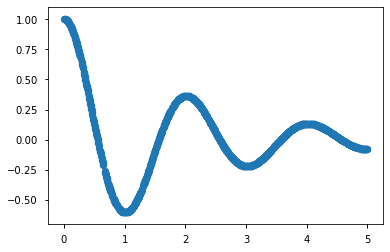

In [23]:
plt.scatter(X_input[0].numpy().squeeze(),solution[:,0])
plt.plot(X,y[:,0])

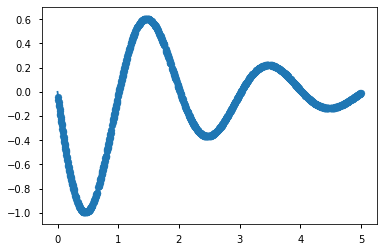

In [24]:
plt.scatter(X_input[0].numpy().squeeze(),solution[:,1])
plt.plot(X,y[:,1])